# Proyecto Final: Modelo para la Detección de Depresión
### Héctor Gibrán González Leal
### A01282778


La depresión es un trastorno mental, afectando a alrededor de 300 millones de personas. Es un problema extremadamente serio, que puede incluso llevar a una persona al suicidio (WHO, 2020). A lo largo de los años, muchas áreas de la ciencia han estudiado a la depresión para entender de mejor manera sus síntomas, comportamientos provocados y curas. Una de estas es la Inteligencia Artificial, donde la subárea de Procesamiento de Lenguaje Natural (NLP) busca desarrollar modelos que puedan detectar patrones de depresión en textos y audios. 

Este notebook contiene la implementación de un modelo de procesamiento de lenguaje natural para la detección de depresión en base a texto. Como se verá más adelante, se aplicó transfer-learning a 3 modelos distintos que incorporan transformadores para hacer la detección. Cabe mencionar que este trabajo fue inspirado por el siguiente paper: https://arxiv.org/abs/1804.07000.

<hr>

## Nota importante
Para que el Notebook pueda trabajar con los archivos que se suben a Colab, como los CSVs que se proporcionan, estos deben estar en el **directorio raíz**. En el repositorio de Github se encuentran dentro de un folder por organización, pero aquí se deben manejar en el directorio raíz, fuera de cualquier folder.

<hr>

Antes que nada, se instalan los módulos necesarios para poder correr el programa.

In [ ]:
pip install -r requirements.txt

     |████████████████████████████████| 163kB 3.3MB/s 
     |████████████████████████████████| 901kB 17.8MB/s 
     |████████████████████████████████| 3.3MB 37.1MB/s 
     |████████████████████████████████| 2.3MB 34.7MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 


Se importan los módulos que se estarán usando:

In [ ]:
import pandas as pd
import numpy as np
import random
import chardet
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

# Modulo de SkLearn para hacer shuffling
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

# Módulo para API de Reddit
import praw
from praw.models import MoreComments

# Módulos de Tensorflow
import tensorflow as tf
import tensorflow_hub as hub

# Módulos de HuggingFace Transformers
from transformers import TFAutoModel, AutoTokenizer

# Módulos de NLTK
import nltk
from nltk.corpus import words, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Descargar paquetes necesarios por si acaso
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# 1. Creacion del Dataset
Algo a lo que se le dio mucha importancia a lo largo de este proyecto fue el set de datos que se estaría alimentando a los modelos, incluso se piensa que un modelo es tan bueno como el set de datos con el que se entrena y evalúa.

Para este proyecto, el set de datos se contruyó a partir de dos pasos: primero tomar datos a partir de una base de datos ya establecida; segundo, complementar esa base de datos con textos recolectados de manera propia. A continuación se explica con mayor detalle lo que se hizo en cada uno de estos pasos. Posteriormente, se explicarán algunas limitaciones y áreas de oportunidad que se encontraron en el set de entrenamiento.

## 1.1 Textos de una base de datos
La base de datos que se utilizó se encuentra en: https://www.kaggle.com/nikhileswarkomati/suicide-watch/version/13. Consiste de textos provenientes de Reddit, particularmente de 3 subreddits en específico: r/depression, r/SuicideWatch y r/Teenagers.

El autor de la base de datos aclara que los textos que recolectó van desde alrededor de enero 2009 (muy cerca de la fecha de creación de estos subreddits) hasta enero 2021. Se piensa que el rango de fechas es bastante amplio, por lo que una ventaja que tiene esta base de datos es que contiene textos y opiniones de usuarios provenientes de años relativamente diferentes, por lo que permite dar una perspectiva muy grande de los posts que hacían los usuarios a través de muchos años diferentes. Esa fue la principal razón por la que se escogió incorporar esta base de datos en el proyecto.

<hr>

## Nota importante
El CSV de esta base de datos no se incluye en el repositorio de este proyecto, debido a que ya está disponible para su descarga directa en la liga que se proporciona.

<hr>


Para traer los textos, primero se leen del CSV que proporciona el autor de la base de datos.

In [ ]:
pd.options.display.max_colwidth = 250

In [ ]:
data = pd.read_csv('SuicideAndDepression_Detection.csv', encoding='ISO-8859-1')

Como se mencionó antes, los textos provienen de 3 subreddits distintos, sin embargo, aquí se enfocó en textos de dos lugares en particular: **depression** y **SuicideWatch**. La razón por la que no se incluyeron los textos de Teenagers es que son textos mucho más volátiles en cuanto a su tono e intención. Así como puede haber publicaciones de usuarios con depresión, puede haber muchas otras publicaciones donde el usuario quiera expresar algo más.

Como se puede ver en la siguiente celda, se tomaron 30,000 textos de r/depression y 20,000 textos de r/SuicideWatch. A todos estos textos se les está asignando una label de **1**, es decir, que todos estos textos se están catalogando como que provienen de usuarios con depresión. La razón principal de esto es que se estuvieron monitoreando publicaciones en estos dos subreddits y se llegó a la conclusión de que **la mayoría de estos textos sí corresponden a un tono depresivo**, que al final del día es lo que se necesita que el modelo pueda detectar. Estos 50,000 textos corresponden a la parte catalogada como **depresiva** del set de datos.

In [ ]:
d = data[data["class"] == "depression"]["text"].sample(30000)
s = data[data["class"] == "SuicideWatch"]["text"].sample(20000)

labels_d = [1 for x in range(len(d))]
labels_s = [1 for x in range(len(s))]

depr = pd.DataFrame(zip(d, labels_d), columns=["Text", "Label"])
suic = pd.DataFrame(zip(s, labels_s), columns=["Text", "Label"])

depression = pd.concat([depr, suic], ignore_index=True)

print(depression.shape)

(50000, 2)


A continuación se muestran algunos de los textos seleccionados, donde de hecho se nota que la mayoría de estos sí tienen un tono depresivo.

In [ ]:
random.seed(12345)
indexes = np.random.randint(1, len(depression), 20).tolist()
depression.iloc[indexes]

,Text,Label
31568,"My son's girlfriend committed suicide, and now his no longer himself.A bit about my son- Before he starting dating his now deceased girlfriend, he was extremely depressed. He broke up with his girlfriend who was his best friend before. That absol...",1
37306,"I tried writing a poem...Void\n\nI feel emptiness inside me\n\nSuffering endlessly\n\nSomeone, anyone,\n\nCan you save me?\n\nWhy am I cast among the filth?\n\nThe degenerates, the maggots?\n\nI am better than they\n\nMade of sterner stuff (or so...",1
2376,Why is drinking the only thing that helps ?I'm not even 20 and most days wanna get pissed at about midday. What's wrong with me ?,1
8410,"I hate everything about myself.I've been morbidly depressed for about five or six years now, and it seems to get worse with each passing year. When it started out, I'd just feel kinda shitty and I wouldn't talk to my friends that much. Now I've f...",1
40039,Well here it is.As you're reading this I'm most likely dead. Tonight I've decided to end it because I just can't anymore. 15 years of pure torture from day 1. Can't wait to meet the afterlife because it's such a freedom. I hope everyone reading t...,1
40396,Things donât seem to get betterIdk what my life is gonna be in my future. Things only seem to get worse over time :/ . My problems arenât normal people problems. I just feel alone,1
25789,"I am relapsing. :(I sought help back in June. And I had people talk to me. I met my counselor yesterday and actually she is an ""addictions counselor"" and originally my main counselor suggested her to me so I can stop smoking, \n\nI was so happy t...",1
35908,i have enough hydroxyzine tablets to kill myselfand i am really tired,1
17525,"Images of Killing MyselfSince proabably about junior high (I'm now 21 years old), I've been having random images come into my head of me killing myself. It'll be multiple times per day, if not almost hourly. For a few seconds I just get images of...",1
28473,"AloneI guess now that I have accepted that I'm going to die alone, never feel someone's love, I hope things will get easier",1


## 1.2 Recolección propia de textos
Dado que ya se tiene la parte de depresión del set de datos, lo siguiente es crear la parte no-depresiva de este, pues el modelo necesita saber diferenciar entre textos de ambas clases. Dado que la base de datos que se usó extrajo sus datos de Reddit, se decidió hacer lo mismo para los textos con tonos no-depresivos.

Como se mencionaba, se utilizó el módulo de PRAW con la API de Reddit para hacer la recolección propia de datos. Es importante mencionar que la finalidad de esta recolección es extraer textos de Reddit que no tengan un tono depresivo. Reddit es una red social muy grande, y afortunadamente tiene espacios para todo tipo de discusiones y todo tipo de personas, por lo que se piensa que es un buen lugar para extraer los textos que se necesitan. Al mismo tiempo, se quería también que los textos fueran variados, que no todos tuvieran el mismo tono (aunque no sea depresivo) dado que tener más variedad en el rango de textos que se incluyen será mejor para el modelo, ya que estará expuesto a textos con diferentes ideas y estructuras.

<hr>

## Nota importante
Para replicar los resultados que se muestran en las secciones posteriores, se debe continuar en la **sección 2.3**, donde ya se incorpora el set de datos finalizado que se guardó. Las siguientes celdas crean streams de datos de Reddit, por lo que si se usan para crear nuevos sets de datos es posible que los resultados no sean similares.

Adicionalmente, se necesita proveer el **client_id** y el **client_secret** de una App del API de Reddit para poder hacer la recolección de datos.


<hr>

Antes que nada, se define el objeto de PRAW con las credenciales de Reddit, para poder traer los textos.

In [ ]:
reddit = praw.Reddit(client_id = '',
                     client_secret = '',
                     user_agent='praw tutorialv1')

Después se define la siguiente función, que recibe como parámetro el nombre de un subreddit, así como un límite. Lo que se hace es que se prende un stream de datos obtenidos del subreddit proporcionado, y cuando llegue al límite se corta el stream. Finalmente se regresan los textos que se guardaron. 

Cabe mencionar que para cada publicación que se recibe del API, se guarda su título y se guardan sus primeros 500 comentarios de primer nivel. Si se tienen menos comentarios se corta antes y se pasa a la siguiente publicación.

In [ ]:
def get_reddit_texts(subreddit, limitPubs, limitTexts, limitComms):
    top_posts = reddit.subreddit(subreddit).top('year', limit=limitPubs)
    texts = []

    for submission in top_posts:
        texts.append(submission.title)
        submission_comm = reddit.submission(id=submission.id)

        for count, top_level_comment in enumerate(submission_comm.comments):
                count_comm = 0
                try :
                    texts.append(top_level_comment.body)

                    if len(texts) >= limitTexts or count_comm >= limitComms:
                        break
                except:
                    continue
        
        print(len(texts))

        if len(texts) >= limitTexts:
            break

    return texts

La siguiente función llama a la anterior para obtener los textos, después, dado que estos textos son **no-depresivos**, se les asigna una label de **0**. Posteriormente ambas cosas se guardan en un CSV para poder utilizarlas después.

In [ ]:
def create_csv(subreddit, filename, limitPubs, limitTexts, limitComms):
    texts = get_reddit_texts(subreddit, limitPubs, limitTexts, limitComms)
    labels = [0 for x in range(len(texts))]
    df = pd.DataFrame(zip(texts, labels), columns=["Text", "Label"])
    df.to_csv(filename, index=False)
    df.head()

Las siguientes celdas obtienen los textos y guardan los CSVs de diferentes subreddits. Se consideraron los siguientes 5 subreddits para sacar datos:
- **ShowerThoughts**
- **MadeMeSmile**
- **Wholesome**
- **HumansBeingBros**
- **UpliftingNews**

Como se puede notar, los 5 subreddits son considerados relativamente felices o agradables, por lo que se cree que forman un buen contraste a las publicaciones que se hacen en Depression y SuicideWatch. También, es importante mencionar que de cada subreddit se quisieron juntar 50,000 datos, aunque en para uno que otro subreddit se juntaron menos (en especial para **r/wholesome**. La idea de esto era complementar los 200 mil datos que contiene la base de datos de Kaggle. No obstante, estos se tuvieron que recortar más adelante para disminuir el tamaño del dataset completo, como se verá más adelante.

In [ ]:
create_csv('showerthoughts', 'ShowerThoughts.csv', limitPubs = 10000, limitTexts = 50000, limitComms = 500)

In [ ]:
create_csv('MadeMeSmile', 'MadeMeSmile.csv', limitPubs = 10000, limitTexts = 50000, limitComms = 500)

In [ ]:
create_csv('wholesome', 'Wholesome.csv', limitPubs = 10000, limitTexts = 50000, limitComms = 500)

In [ ]:
create_csv('HumansBeingBros', 'HumansBeingBros.csv', limitPubs = 10000, limitTexts = 50000, limitComms = 500)

In [ ]:
create_csv('UpliftingNews', 'UpliftingNews.csv', limitPubs = 10000, limitTexts = 50000, limitComms = 500)

La siguiente celda es para poder utilizar los CSVs que se guardaron, con el objetivo de que los textos sean consistentes y no se construyan nuevos sets de datos cada que se abre el proyecto.

In [ ]:
shower_thoughts = pd.read_csv('ShowerThoughts.csv', encoding='ISO-8859-1')
made_me_smile = pd.read_csv('MadeMeSmile.csv', encoding='ISO-8859-1')
uplifting_news = pd.read_csv('UpliftingNews.csv', encoding='ISO-8859-1')
wholesome = pd.read_csv('Wholesome.csv', encoding='ISO-8859-1')
humansBeingBros = pd.read_csv('HumansBeingBros.csv', encoding='ISO-8859-1')

Finalmente, el conjunto de datos de los 5 subreddits distintos se combina en un solo DataFrame para crear uno solo que contenga todos los textos catalogados como no-depresivos. Las siguientes dos celdas guardan un CSV con el nuevo DataFrame creado y también leen el archivo del CSV, tal y como se hizo anteriormente.

In [ ]:
non_depression = pd.concat([shower_thoughts, made_me_smile, uplifting_news, wholesome, humansBeingBros], ignore_index=True)

In [ ]:
non_depression.to_csv("NonDepression.csv", index=False)

In [ ]:
non_depression = pd.read_csv('NonDepression.csv', encoding='ISO-8859-1')

## 1.3 Limitaciones del set de datos
Ahora ya se tienen las dos partes principales del set de datos, a partir del cual se obendrán los sets de entrenamiento, validación y testing. Sin embargo, es importante mencionar que este set de datos no es perfecto, presenta unas limitaciones y sesgos bastante claros y que naturalmente afectan el rendimiento de los modelos, pero más importante que eso afectan la interpretación que se necesita hacer de los resultados, dado que lo que sale no necesariamente refleja la completa realidad.

A continuación se explican las principales limitaciones y sesgos que se encontraron:


1. **Catalogar todos los textos de un subreddit de la misma forma**. Se cree que esta es la más grande limitación que presenta el set de datos. Como se mencionó antes, Reddit es un lugar sumamente grande donde gente de todas partes comparte sus ideas y se presentan discusiones sobre las mismas. Y aunque estas ideas sí se dividen por tema con los diferentes subreddits, dentro de un mismo subreddit sigue habiendo una variedad impresionante de publicaciones. Debido a esto, decir que todos los textos dentro de r/depression son depresivos, puede que sea una generalización muy grande. No obstante, sí se estudiaron algunos textos que se reclectaron, y la gran mayoría sí tenían tono depresivo, en el caso de r/depression, por lo que esta decisión se tolerará para el proyecto.


2. **La cantidad de los datos que se terminó usando**. Sí se mira en detalle la base de datos de Kaggle que se trajo para el proyecto, se puede ver que esta contiene poco más de 300 mil textos, alrededor de 200 mil contando solo los de depression y SuicideWatch, pero para el set de datos final se terminaron tomando solamente 50 mil de estos. Igulamente para los que se recolectaron, se terminaron juntando 10 mil de cada subreddit para completar los 100 mil. Esto claramente es poco considerando la cantidad de datos que se pudo haber usado, sin embargo, esto se dejó así por dos razones: primero por el tiempo que le tomaría a los modelos procesar tantos textos; segundo, como se verá más adelante se usaron modelos ya pre-entrenados, por lo que 100 mil textos se consideró suficiente para hacer el transfer learning.


3. **La calidad general de los textos**. Esta limitación es algo que está completamente fuera de control, pero aún así vale la pena mencionarla. Cualquier persona puede escribir una publicación o comentario en Reddit, por lo que muchas veces la calidad de los textos no es la deseada, hay errores de ortografía, puede haber palabras ofensivas, entre muchas otras cosas. Sin embargo, el otro lado de la moneda es que estos textos de verdad reflejan lo que las personas están pensando, aunque su uso del lenguaje no sea siempre el más adecuado, por lo que termina quedando muy bien para un modelo como este, que quiere detectar un sentimiento específico en las personas.


4. **Varianza en la longitud de los textos**. Esta es quizás la limitación menos importante, debido a que los modelos están preparados para manejar textos de diferentes longitudes. El problema es que, dentro del dataset es muy posible que haya una varianza muy grande en las longitudes. Por ejemplo, puede que haya comentarios como 'Well done!', con sólo dos palabras; y por el otro lado, puede que haya textos de 200 o 300 palabras argumentando su punto de vista en una discusión. Nuevamente, esto no es un problema grande, pero sí es uno que se identificó y por eso se incluye aquí.

En general, aún con estas limitaciones se está contento con el set de datos que se pudo construir, y se piensa que a partir de él se pueden obtener resultados muy buenos. A continuación, se explican los pasos de preprocesamiento que se hicieron sobre los textos antes de alimentarlos a los modelos. También, se mostrarán algunas visualizaciones de los datos para más claridad.



# 2. Preprocesamiento
Tras estudiar algunos de los textos que vienen en el dataset, es claro que se necesita realizar un preprocesamiento de la información, con el objetivo de minimizar el ruido de los datos y los errores presentes, así como preparar los textos para que los modelos los puedan consumir de mejor forma. Este fue el proceso que se siguió para llevar a cabo este preprocesamiento:

1. **Eliminar los valores nulos/inservibles:** al modelo no se pueden alimentar valores nulos, por lo que hay que quitarlos del dataset. Pero además de eso, hay algunas entradas que sólo contienen la palabra "[deleted]" o "[removed]", que significa que la publicación o comentario fue eliminado en Reddit, pero el API aún así la trajo. Estas hay que eliminarlas también, pues no sirven.

2. **Juntar la parte de depresión con la de no-depresión y hacer shuffle:** hasta ahora se habían mantenido separadas las dos partes del set de datos, por lo que se necesitan juntar en un solo dataset. Dado que se van a juntar una tras la otra, se necesita hacer un shuffle posteriormente para que el training, validation, y testing set reciban textos de ambas categorías.

3. **Correr los datos por una función de preprocesamiento:** ya que se tenga un solo dataset con toda la informacion, todos los textos se van a pasar por una función que se diseñó para procesarlos. Más adelante se explica en profundo detalle en qué consiste esta función.

4. **Eliminar los valores que hayan resultado nulos o vacíos tras procesarlos:** Tras hacer algunas pruebas, se notó que algunos textos resultan nulos tras el procesamiento, por lo que se volverá a revisar y a eliminar aquellos que hayan quedado como nulos o vaciós.

## 2.1 Eliminar los valores nulos/inservibles
Primero se muestran algunos ejemplos donde los textos aparecen como "[deleted]" o "[removed]"

In [ ]:
non_depression[non_depression["Text"] == "[deleted]"]
non_depression[non_depression["Text"] == "[removed]"]

,Text,Label
406,[removed],0
646,[removed],0
805,[removed],0
2520,[removed],0
2893,[removed],0
...,...,...
209687,[removed],0
209693,[removed],0
209703,[removed],0
209829,[removed],0


Utilizando numpy, se obtienen los índices donde se presentan estas dos palabras, y se borran del DataFrame con *drop*. 

In [ ]:
removed_rows = np.where(non_depression["Text"] == "[removed]")[0]
non_depression.drop(removed_rows, axis=0, inplace=True)
non_depression.reset_index(drop=True, inplace=True)

In [ ]:
deleted_rows = np.where(non_depression["Text"] == "[deleted]")[0]
non_depression.drop(deleted_rows, axis=0, inplace=True)
non_depression.reset_index(drop=True, inplace=True)

Del resultado se toma un sample aleatorio de 50 mil textos. Como se mencionó antes, este CSV contenía alrededor de 200 mil textos. Sin embargo, aquí se recorta a 50 mil para complementar la parte de los textos depresivos y que el dataset resultante tenga 100 mil textos.

In [ ]:
non_depression = non_depression.sample(50000)
non_depression.shape

(50000, 2)

## 2.2 Juntar la parte de depresión con la de no-depresión y hacer shuffle
Ahora sí, se construye el dataset completo concatenando la parte de depresión con la parte de no-depresión.

In [ ]:
dataset = pd.concat([depression, non_depression], ignore_index=True)

Por si acaso, se vuelve a revisar que no haya nulos en el dataset ya completo.

In [ ]:
np.where(pd.isnull(dataset))[0]

array([70245])

Como resultó que sí hubo un valor nulo, se obtiene su índice y se droppea del DataFrame. Posteriormente se muestra la información del DataFrame resultante.

In [ ]:
null_rows = np.where(pd.isnull(dataset))[0]
dataset.drop(null_rows, axis=0, inplace=True)
dataset.reset_index(drop=True, inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    99999 non-null  object
 1   Label   99999 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


Ahora sí, ya que se sabe que no hay nulos, se le hace un shuffle al dataset utilizando la función que proporciona SciKitLearn. Posteriormente se muestran algunos textos para tener una visualización de lo que está pasando. 

In [ ]:
dataset = shuffle(dataset)
dataset.head(15)

,Text,Label
22629,Mark Zuckerberg??,0
81144,"Dunno, there's no hiding it.",0
35881,"He looks like a baby Chewbacca, so damn cute Ã¢ÂÂºÃ¯Â¸Â",0
85709,"I wish I never made it this farI honestly which I killed myself by now, I hate life, I hate being alone, I hate everything and person toxic in my life, I hate being around... I was exposed to Covid19 start of Dec and I survived that which I reall...",1
17929,Some problems can't be talked out of.I reached the end a few years ago. I've been hanging out and waiting for the courage to kill myself but I've never been able to even in the most intense periods of pain. I wish I was stronger. There have been ...,1
19793,overdosing tonight. sorry guys.i think i might overdose tonight. its fucking hopeless its literally fucking hopeless im a lose cause. my mom is abusive and i was finishign up an art commission downstairs and i asked when my next psychiatrist meet...,1
78151,"I've had depression for over ten years... here's my story. It really does get better!I refuse to post this to a throwaway account, and I'm always encouraging people to share with me and I'd be a complete hypocrite if I wasn't my total honest, tru...",1
75156,Karma farming,0
55927,"Im about to show how big of a failure I amI have my physics final tomorrow, and i've been trying to study for it. I dont understand half the content i have to study from. I flunked two tests so far, and am borderline failing this class that my pa...",1
71633,First the Titanfall series and now this?\n\nMy favorite game company so far,0


Como se puede ver, hay algunos caracteres que pareciera que no se procesaron correctamente, quizás hubo algún error con el encoding de los textos. Para tener mejor certeza, se verifica cuál es el encoding de los textos uilizando *chardet*.

In [ ]:
with open("Dataset.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

print(result)

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


Dado que el resultado fue utf-8, se piensa que quizás hubo un error con el encoding de los textos de 'no-depression', que como se vio para esos se utilizó 'ISO-8859-1'. Como parece que solamente el caracter del apostrofe resultó con error, se hace el reemplazo manual de los caracteres raros que se muestran por el caracter del apostrofe.

In [ ]:
t = dataset.iloc[0]["Text"]
print(t.replace('â\x80\x99', "'"))

dataset["Text"] = dataset["Text"].apply(lambda x: str(x).replace('â\x80\x99', "'"))

Mark Zuckerberg??


Una vez que se hace la sustitución, el dataset completo se guarda en un CSV para su uso más adelante.

**Nota importante**: este dataset es el que se usa para crear los sets de training, validation y testing.

In [ ]:
dataset.to_csv("Dataset.csv", index=False)

## 2.3 Correr los datos por una función de preprocesamiento
Lo primero que se hace es leer el CSV del dataset

In [ ]:
dataset = pd.read_csv('Dataset.csv', encoding='utf-8')

Ya con el archivo del dataset armado y leído, se puede pasar al procesamiento de los textos en sí. Primero, utilizando NLTK se define un set de **stopwords** que se estarán removiendo de los textos. Nótese que primero se define una lista de palabras con connatación negativa, estas es importante quitarlas del set de stopwords dado que sí pueden alterar el significado o intención del texto, a diferencia de palabras como 'the' que no terminan siendo muy importantes pero sí están muy presentes en los textos.

In [ ]:
negatives = ['no', 'not', 'none', 'hasn', "shan't", 'wouldn', "won't", "weren't", "didn't", 'isn', "couldn't", 'weren', "wouldn't", "don't", "doesn't", 'mustn', "hadn't", 'needn', "haven't", "aren't", "wasn't", "isn't", "mustn't", "ain't", "needn't"]
stop_words = set(stopwords.words("english") + [',', '...', '.', '..', "'", '’', 'rt', ':']) - set(negatives)

Se definieron dos funciones para realizar el procesamiento de los textos. A continuación se describe la funcionalidad de cada una.

La primera función cumple dos propósitos: **lemmatizar** y **tokenizar** los texto que recibe. Con la primera, se quiere regresar las palabras a su raíz, con el objetivo de que palabras como 'running' y 'ran' se tomen como la misma. Y la segunda, va a dividir el texto del tweet en palabras, y estas se regresarán en una lista. Además de esto, es importante mencionar que sólo se incluyen palabras que **no sean stopwords**, por la razón que estas no terminan aportando al sentimiento del tweet, tal y como se mencionó arriba.

In [ ]:
def lemmatize_tokenize(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(token.lower()) for token in word_tokenize(text) if token not in stop_words])

La segunda función va a quitar o arreglar ciertas cosas que se notaron en los textos y que se cree que no aportan mucho para determinar su clasificación. Más específicamente, se hace lo siguiente:

*   **Remover menciones a otros subreddits**, dado que no se cree que estos afecten el significado del texto.
*   **Remover menciones a usuarios de Reddit**, dado que se considera importante que los textos permanezcan lo más anónimo que sea posible, tal como lo hicieron los autores del paper sobre el cuál está basado este proyecto.
*   **Sustituir los emojis**, al igual que los hashtags, se piensa que sería mucho más útil agrupar todos los emojis positivos y separarlos de los negativos.
*   **Remover los URLs**, en el sentido de que se removerán los caracteres especiales y sólo se dejarán las palabras importantes de este.
*   **Remover caracteres repetidos**, para agrupar palabras como 'heelloooo' en una sola
*   **Remover caracteres de control de strings**, se notó que muchos de los textos contienen caracteres como '\n' y '\t', se decidió quitarlos para que no hagan ruido en los textos.

Finalmente, esta función regresa el texto procesado por la función anterior para así guardarlo.

In [ ]:
def process_text(text):
    # Remover menciones a subreddits
    text = re.sub(r"\/r\/([^\s/]+)", r"", text) # regex tomada de https://stackoverflow.com/questions/21109968/python-regex-to-match-subreddit-names

    # Remover menciones a otros usuarios de Reddit
    text = re.sub(r"\/u\/([^\s/]+)", r"", text) # regex tomada de https://stackoverflow.com/questions/46104630/regex-to-identify-reddit-usernames

    # Reemplazar los emojis
    HAPPY_EMO = r"([xX;:]-?[dD\)]|:-?[\\\)]|[;:][pP])" # tomada de https://stackoverflow.com/questions/28077049/regex-matching-emoticons
    SAD_EMO = SAD_EMO = r"(:'?[/|\(])" # tomada de https://stackoverflow.com/questions/28077049/regex-matching-emoticons

    text = re.sub(HAPPY_EMO, " happyemoticon ", text)
    text = re.sub(SAD_EMO, " sademoticon ", text)

    # Remover los URLs
    text = re.sub(r"htpps?://\S+|www\.\S+", "", text)

    # Remover caracteres repetidos
    text = re.sub(r"(.)\1+", r"\1\1", text)

    # Remover caracteres de control de strings
    text = re.sub(r"[\n\r\t]", r" ", text)

    return text

Ya con las funciones definidas, se toman los textos del dataset y se pasan por ambas funciones para obtener la lista de los textos procesados. También se arma una lista con las labels del dataset. Ambas cosas se estarán usando para generar los sets de training, validation y testing. 

In [ ]:
processed_ds = dataset.Text.map(lambda text: lemmatize_tokenize(process_text(text)))

In [ ]:
labels = dataset.Label

## 2.4 Eliminar los valores que hayan resultado nulos o vacíos tras procesarlos
Como se mencionó, tras hacer algunas pruebas hubo casos en los que salían errores debido a valores vacíos o nulos en la lista de textos ya procesados. Debido a eso, se volvió a buscar los índices donde esto ocurra y se eliminaron de ambas listas, tanto de los textos como de los labels. Es importante remover las mismas entradas de ambas listas, dado que si no se crearía un desfase y los modelos aprenderían sobre los datos erróneos.

In [ ]:
null_rows = np.where(processed_ds == "")[0]

In [ ]:
processed_ds.drop(null_rows, axis=0, inplace=True)
processed_ds.reset_index(drop=True, inplace=True)

labels.drop(null_rows, axis=0, inplace=True)
labels.reset_index(drop=True, inplace=True)

## 2.5 Visualización de los datos

Es importante tener una buena visualización de los datos que se van a estar usando con los modelos. En este caso, primero se decidió construir una gráfica que compare la cantidad de textos etiquetados como depresivos con aquellos etiquetados como no-depresivos. 

La siguiente celda calcula la cantidad de textos con cada una de las etiquetas.

In [ ]:
zeros_count = len(np.where(labels == 0)[0])
ones_count = len(np.where(labels == 1)[0])

De ahí, se utiliza esta información para construir una gráfica de barras, algo sencilla, pero importante porque nos muestra que la cantidad de textos sí quedó prácticamente balanceada aún después de todo el preprocesamiento y de haber quitado varios reglones que no servían.

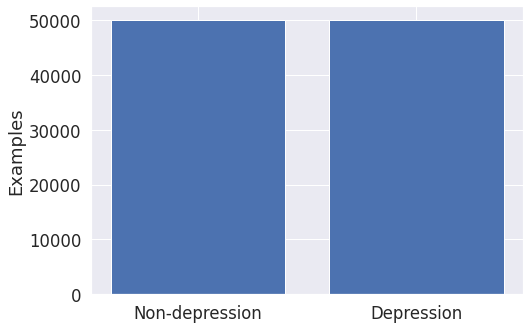

In [46]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Non-depression', 'Depression']
students = [zeros_count, ones_count]
ax.bar(langs,students)
ax.set_ylabel('Examples')
plt.show()

Lo segundo que se hizo fue obtener el promedio y la mediana de la logitud de los textos. Esto ayudará más adelante en definir el tamaño de los embeddings que se estarán alimentando a los modelos. La idea con este tamaño es que no sea muy grande, para que no alente mucho a los modelos, pero tampoco puede ser muy chico, si fuera así se terminarían truncando muchos de los textos.

In [ ]:
text_lengths = [len(text) for text in processed_ds]
print(f"The mean of the text lengths is {np.mean(text_lengths)}")
print(f"The median of the text lengths is {np.median(text_lengths)}")

The mean of the text lengths is 436.2258823058527
The median of the text lengths is 144.0


Como se puede ver, el promedio de longitudes está por encima de 400 palabras. Esto significa que hay textos muy largos, pro encima de 500 palabras, pero también hay muchos muy cortos. Incluso es posible que haya textos extremadamente grandes, 1000+ palabras, que terminan afectando el promedio. Por eso, la longitud de secuencia que se usará será algo más cercano a la mediana, que resultó en 144. Se piensa que **200** es un buen tamaño, ya que, al estar después de la mediana significa que no se estarán truncando muchos de los textos, pero también es importante considerar que 200 no es un tamaño muy grande, por ejemplo si se compara con el máximo tamaño que puede aceptar BERT de 512 palabras.

# 3. Selección y entrenamiento de modelos
Ahora sí, ya que se tiene el dataset construido y comprendido, la siguiente etapa consiste en la construcción, entrenamiento y evaluación de los modelos. Primero se va a explicar la selección de los modelos junto con el razonamiento que se tuvo para cada uno. Después, se va a mostrar el proceso para construir los training, validation y testing sets apropiados para cada modelo. Una vez que se tengan, se procede a definir los hiperparámetros, así como las funciones de costo y optimización que se estarán usando.

Finalmente, se mostrará el entrenamiento de los modelos, junto con sus métricas de evaluación resultantes. Cabe mencionar que para cada uno, justo después de su evaluación, se harán observaciones sobre los resultados y se mencionarán algunas limitaciones que tiene el modelo.

## 3.1 Modelos Seleccionados
A continuación se describen los 3 modelos que se implementaron:

### BERT
BERT fue introducido en el siguiente paper: https://arxiv.org/pdf/1810.04805.pdf. Las características principales que definen a este modelo es que aplica una técnica bidireccional de entrenamiento al transformador para el modelamiento del lenguaje. Esto lo ayuda a que tenga un mejor sentido del contexto y flujo del texto que está procesando. Los autores hicieron esto usando una técnica que llamarom **Masked Language Modeling (MLM)**, en la cual 15% de las palabras en cada secuencia son reemplazadas por un token [MASK]. Después tratan que el modelo prediga los valores originales, basado en el contexto por las palabras no enmascaradas.

La otra técnica de entrenamiento que usaron los autores es llamada **Next Sentence Prediction**, donde el modelo recibe pares de oraciones como entrada y aprende a predecir si la segunda oración es subsecuente a la primera en el documento original. 50% de las entradas sí lo son, mientras que el resto no lo son. 

Se está entrando en mucho detalle en BERT, debido a que los siguintes modelos tomaron inspiración, sino es que están basados en BERT.

Las **limitaciones principales** que tiene BERT son:
- Solamente puede manejar secuencias de hasta 512 tokens
- Corrompe las entradas al modificarlas para usar los tokens de [MASK]
- No toma en cuenta la dependencia entre tokens enmascarados

### RoBERTa
Fue introducido por Facebook, y la idea era presentar un acercamiento robustamente optimizado a lo que se presentó con BERT. Este es el paper original: https://arxiv.org/abs/1907.11692. Los autores decidieron enfocar este modelo en el objetivo de MLM de BERT, desechando por completo el objetivo de NSP. Esto les permitió modificar hiperparámetros clave de BERT para enfocarse en ese objetivo y alcanzar el estado-del-arte en varias tareas distinas.

Las **limitaciones principales** que tiene RoBERTa son:
- Se podría decir que este modelo pueda compartir las limitaciones que BERT tiene, dado que, como mencionan los autores del paper, "BERT no estaba lo suficientemente entrenado, por lo que pusimos unas mejoras para eso."

### XLNet
El tercer y último modelo que se implementó fue llamado XLNet. De igual manera, también toma algunas de sus ideas de BERT, sin embargo, hace un cambio clave al objetivo de entrenamiento. XLNet lo que busca es aprender las distribuciones condicionales para todas las permutaciones de los tokens en una secuencia, llamado **Permutation Language Modeling**. Es un acercamiento diferente pero que también puede capturar el contexto bidireccional utilizando información contextual. El paper original es: https://arxiv.org/abs/1906.08237.

**Limitaciones**:

Para XLNet no se pudieron encontrar limitaciones específicas, lo cual tiene sentido dado que es de lo más nuevo que ha salido. Sin embargo, es claro que cuando se tenga más tiempo de analizar el modelo se irán mostrando sus desventajas. Personalmente, para este proyecto una limitación fue que XLNet fue el modelo que más tiempo tomó para entrenar, y cmo se verá más adelante, fue el que obtuvo peores resultados, quizás porque no se hizo transfer learning por el tiempo apropiado.





Estos modelos claramente son el estado-del-arte actual en cuanto a procesamiento de lenguaje natural. Esa es la razón principal por la que se querían incluir en el proyecto, ya que sería una muy buena experiencia de aprendizaje poder trabajar con dichos modelos. En cuanto a la implementación en sí, se está utilizando el módulo de **Transformadores** construido por **HuggingFace** para importar los modelos ya pre-entrenados. Se pueden encontrar en: https://huggingface.co/models. Una vez que se importan, se aplica transfer learning para que los modelos aprendan del dataset que se construyó aquí y puedan sacar resultados específicos para eso.

## 3.2 Plan de entrenamiento
### Hiperparámetros
Los hiperparámetros se manejaron de dos formas, primero para la construcción de los sets de datos y los embeddings de las entradas; y segundo, para el entrenamiento de los modelos.

Para el primer punto se utilizó:
- Training set size de 70% de los datos
- Validation set size de 15% de los datos
- Testing set size de 15% de los datos
- Embedding sequence length de 200 tokens máximo, si la secuencia es menor se agrega padding, si es mayor se trunca.

Para el segundo punto se utilizó:
- Batch size de 128
- Learning rate de 0.01
- Epochs de 2

### Función de costo y optimización
- La función de costo usada fue Binary Crossentropy, la función que provee Keras
- Para el optimizador se utilizó Adam tradicional, igualmente la función que provee Keras

### Técnicas para evitar under- y overfitting
- En cuanto a underfitting, dado que los modelos ya están pre-entrenados y sólo se quiere hace transfer learning, se piensa que es muy difícil que el modelo haga underfitting, por lo que no se utilizó una técnica en específico.
-En cuanto a overfitting, se introdujo una capa de Dropout a la arquitectura de los modelos, junto con algunas otras capas, como GlobalAveragePooling y Dense, para conformar la aqruitectura completa del modelo.
- Se puede decir que inclusive el recorte de datos en el dataset de 400 mil a 100 mil también ayudó a que el modelo no cayera en overfitting.



## 3.3. Métricas de desempeño
Las métricas de evaluación se utilizaron son:
- Binary Accuracy
- Precision
- Recall
- Confusion matrix que provee ScikitLearn

Desde que se dedujeron las limitaciones del set de datos, que se trataron en la sección 1.3, se supo que quizás la **accuracy** no sería la métrica de evaluación más apropiada para evaluar los modelos. Aún así se calculó, dado que se piensa que todavía tiene algo de valor. Como se había mencionado antes, se hicieron generalizaciones grandes al hacer el etiquetado, por lo que puede que haya falsos positivos y negativos en el dataset, sobre todo los primeros. Por esta razón, se piensa que **precision** es la métrica más apropiada, ya que al sólo fijarse en los positivos, tanto verdaderos como falsos, da una muy buena idea de la calidad del modelo.

**Recall** se piensa que también fue una buena métrica, más que todo porque ayuda a rectificar aún más que los modelos sí tuvieron buenos resultados, complementando la precisión.

La parte más importante de la evaluación fue sin duda construir la matriz de confusión, ya que se piensa que aquí es donde mejor se puede visualizar cómo está trabajando el modelo. Inclusive, se implementó una función para saacar una gráfica más visual de la matriz utilizando el módulo de *Seaborn*.

En general, se piensa que estas 3 métricas principales se complementan entre las 3 para dar una muy buena evaluación, o tener una perspectiva muy completa de lo que está haciendo el modelo. Más adelante, para cada modelo se muestran sus respectivas métricas junto con su gráfica de la función de costo, así como la gráfica de la matriz de confusión.

Habiendo dicho esto, a continuación se explica la implementación específica para los modelos.

La siguiente celda descarga los 3 modelos de HuggingFace, junto con su respectivo tokenizer. Como se puede notar, se guardan los 3 modelos aparte, y lo mismo se hace con sus tokenizers. Los modelos que se están descargando son los que se mencionaron previamente.

In [ ]:
bert = TFAutoModel.from_pretrained('bert-base-cased')
tokenizerBert = AutoTokenizer.from_pretrained('bert-base-cased')

roberta = TFAutoModel.from_pretrained('roberta-base')
tokenizerRoberta = AutoTokenizer.from_pretrained('roberta-base')

xlnet = TFAutoModel.from_pretrained('xlnet-base-cased')
tokenizerXlnet = AutoTokenizer.from_pretrained('xlnet-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


Aquí se definen algunos de los hiperparámetros básicos que se mencionaron.

In [ ]:
SEQ_LEN = 200
BATCH_SIZE = 128
LEARNING_RATE = 0.01
EPOCHS = 2
DS_LEN = len(processed_ds)

train_size = int(0.7 * DS_LEN)
val_size = int(0.15 * DS_LEN)
test_size = int(0.15 * DS_LEN)

## 3.4 Creación de training, validation y testing sets
A continuación se implementan 3 funciones necesarias para crear los 3 sets de datos necesarios. Cabe mencionar que estos ya no tendrán los textos como tal, sino que contendrán los embeddings generados por el tokenizer de cada modelo.

La primera función genera el embedding de un texto. Nótese que recibe el objeto del tokenizer como argumento, debido a que se le estará mandando un tokenizer diferente dependiendo de para cual modelo se estén generando los embeddings. Regresa los inputs IDs, así como la attention mask generada.

In [ ]:
def tokenize(sentence, tokenizer):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

La segunda función sirve simplemente para genera un diccionario que contenga los input IDs y la attention mask. Regresa el diccionario generado junto con las labels que recibe.

In [ ]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

La terera función es la más importante. Utiliza las dos anteriores para generar el dataset tokenizado. A partir de los input IDs y attention mask de todas las secuencias, crea un Tensorflow Dataset, que será el que se va a estar alimentando a los modelos.

In [ ]:
def create_tokenized_ds(ds, labels, tokenizer):
    text_ids = np.zeros((len(ds), SEQ_LEN))
    text_mask = np.zeros((len(ds), SEQ_LEN))

    for i, sentence in enumerate(ds):
        text_ids[i, :], text_mask[i, :] = tokenize(sentence, tokenizer)

    new_ds = tf.data.Dataset.from_tensor_slices((text_ids, text_mask, labels))
    new_ds = new_ds.map(map_func)
    new_ds = new_ds.batch(BATCH_SIZE)

    return new_ds

Aquí se crean los 3 sets de datos para cada uno de los modelos. A decir verdad, no se probó si el mismo set de datos funcionaría para los 3 modelos, pero se piensa que es mejor sacrificar el espacio extra de tener los 9 sets, debido a que muy probablemente cada tokenizer genera los embeddings optimizados para su propio modelo, y se quiere aprovechar ese punto.

In [ ]:
train_ds_bert = create_tokenized_ds(processed_ds[:train_size], labels[:train_size], tokenizerBert)
val_ds_bert = create_tokenized_ds(processed_ds[train_size : (train_size+val_size)], labels[train_size : (train_size+val_size)], tokenizerBert)
test_ds_bert = create_tokenized_ds(processed_ds[(train_size+val_size):], labels[(train_size+val_size):], tokenizerBert)

train_ds_roberta = create_tokenized_ds(processed_ds[:train_size], labels[:train_size], tokenizerRoberta)
val_ds_roberta = create_tokenized_ds(processed_ds[train_size : (train_size+val_size)], labels[train_size : (train_size+val_size)], tokenizerRoberta)
test_ds_roberta = create_tokenized_ds(processed_ds[(train_size+val_size):], labels[(train_size+val_size):], tokenizerRoberta)

train_ds_xlnet = create_tokenized_ds(processed_ds[:train_size], labels[:train_size], tokenizerXlnet)
val_ds_xlnet = create_tokenized_ds(processed_ds[train_size : (train_size+val_size)], labels[train_size : (train_size+val_size)], tokenizerXlnet)
test_ds_xlnet = create_tokenized_ds(processed_ds[(train_size+val_size):], labels[(train_size+val_size):], tokenizerXlnet)

## 3.5 Construcción de los modelos
Las siguientes celdas implementan las funciones para la construcción de los modelos. Primero se definen algunas funciones que serán muy útiles, y después se construyen los modelos en sí.

La primera función, toma el historial de un modelo y genera la gráfica de la función de costo para el set de entrenamiento y el de validación.

In [ ]:
def plot_history_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

La segunda función toma un modelo y toma el set de testing. Aquí se generan las predicciones de ese modelo con el set de datos recibido, y posteriormente utilizando dichas predicciones, así como las labels reales, se genera la gráfica de la matriz de confusión para ese modelo.

In [ ]:
def plot_confusion_matrix(model, test_ds):
    predictions = np.round(model.predict(test_ds).flatten())    
    test_labels = labels[(train_size+val_size):]

    cm = confusion_matrix(test_labels, predictions)
    df_cm = pd.DataFrame(cm, columns=['No-depresivo', 'Depresivo'], index=['No-depresivo', 'Depresivo'])

    sn.set(font_scale=1.5) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()

La tercera función define la arquitectura del modelo y genera el objeto de Keras listo para compilarse. Aquí hay dos cosas que valen la pena mencionar:
- La primera es que se está utilizando la misma arquitectura para los 3 modelos. Lo cual es cierto, pero solo en parte, por un lado, sí se están agregando algunas capas aquí, pero estas son principalemnte para acomodar los inputs y para evitar el overfitting con dropout. Por el otro lado, la capa del transformador, la principal en el modelo, va a ser distinta, que es lo más importante.
- El segundo punto es que se está utilizando el API Funcional de Keras. Esto es más una nota personal, dado que nunca se había trabajo con este API, siempre con el secuencial.

In [ ]:
def create_model(transformer):
    input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

    embeddings = transformer(input_ids, attention_mask=mask)[0]

    X = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dense(128, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.1)(X)
    y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(X)

    return tf.keras.Model(inputs=[input_ids, mask], outputs=y)

Ya con la función para crear el modelo lista, lo único que resta es definir la función de costo, el optimizador, así como las métricas de evaluación que proporciona Keras.

In [ ]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
acc = tf.keras.metrics.BinaryAccuracy('accuracy')
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

Finalmente, lo único restante es construir, entrenar y evaluar los modelos específicos. Para esta parte se siguieron los siguientes pasos:
1. **Se construye y compila el modelo**. Hay que hacer énfasis que en todos los modelos la capa con índice 2, la correspondiente al transformador, se marcó como **no-entrenable**, de tal forma que se estará usando tal y como se importó de HuggingFace.

2. **Se entrena el modelo y se obtiene su historial**. Es importante guardar el historial para poder obtener la gráfica de la función de costo.

3. **Se calculan las métricas de evaluación y la gráfica de costo**. Para tener una idea de cómo le fue al modelo.

4. **Se calcula la matriz de confusión**. Para ver con exactitud qué es lo que predijo el modelo.

5. **Observaciones personales**. Nadamas para notar algunas cosas interesantes que salieron del modelo.

## 3.6 BERT
Aquí se muestra todo lo relacionado al modelo de BERT

In [ ]:
bert_model = create_model(bert)
bert_model.layers[2].trainable = False
bert_model.summary()
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[acc, precision, recall])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
history_bert = bert_model.fit(train_ds_bert, validation_data=val_ds_bert, epochs=EPOCHS)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


547/547 [==============================] - 2137s 4s/step - loss: 0.1192 - accuracy: 0.9601 - precision: 0.9653 - recall: 0.9546 - val_loss: 0.0921 - val_accuracy: 0.9669 - val_precision: 0.9692 - val_recall: 0.9640
Epoch 2/2
547/547 [==============================] - 2118s 4s/step - loss: 0.0931 - accuracy: 0.9668 - precision: 0.9715 - recall: 0.9620 - val_loss: 0.0853 - val_accuracy: 0.9704 - val_precision: 0.9807 - val_recall: 0.9595


118/118 [==============================] - 347s 3s/step - loss: 0.0786 - accuracy: 0.9717 - precision: 0.9802 - recall: 0.9633
Test Loss: 0.07860369980335236
Test Accuracy: 0.9717182517051697
Test Precision: 0.9801619648933411
Test Recall: 0.9632626175880432



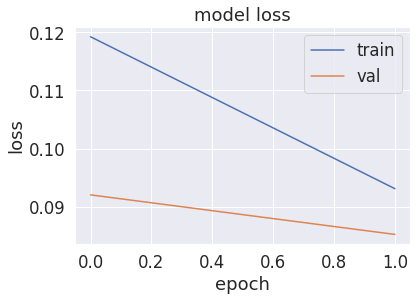

In [ ]:
l, a, p, r = bert_model.evaluate(test_ds_bert)

print('Test Loss:', l)
print('Test Accuracy:', a)
print('Test Precision:', p)
print('Test Recall:', r)
print()
plot_history_loss(history_bert)

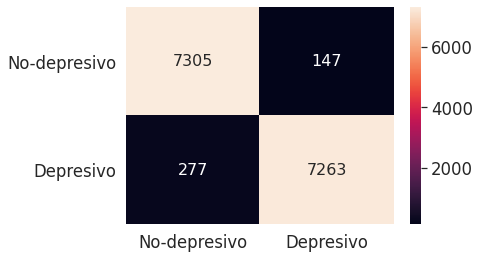

In [ ]:
plot_confusion_matrix(bert_model, test_ds_bert)

### Observaciones
Algo que se notó de inmediato fue que el modelo desde el principio tuvo muy buenas métricas. El modelo se entrenó por 2 épocas, pero aún así desde el principio del entrenamiento tuvo excelentes resultados. Como se puede ver en sus métricas, las 3 están bastante altas, pero aquí las importantes son precision y recall, que también resultaron muy bien.

Es también importante mencionar la matriz de confusión, que como se puede ver está tal y como se esperaría para un modelo con métricas tan altas. Se puede decir que el modelo no necesitó mucho transfer learning para poder sacar buenas predicciones en esta aplicación.

## 3.7 RoBERTa
Aquí se muestra todo lo relacionado al modelo de RoBERTa

In [ ]:
roberta_model = create_model(roberta)
roberta_model.layers[2].trainable = False
roberta_model.summary()
roberta_model.compile(optimizer=optimizer, loss=loss, metrics=[acc, precision, recall])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 768)          0           tf_roberta_model[0][0]     

In [ ]:
history_roberta = roberta_model.fit(train_ds_roberta, validation_data=val_ds_roberta, epochs=EPOCHS)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


547/547 [==============================] - 2102s 4s/step - loss: 0.1947 - accuracy: 0.9621 - precision: 0.9675 - recall: 0.9565 - val_loss: 0.0863 - val_accuracy: 0.9709 - val_precision: 0.9712 - val_recall: 0.9702
Epoch 2/2
547/547 [==============================] - 2108s 4s/step - loss: 0.0871 - accuracy: 0.9698 - precision: 0.9737 - recall: 0.9657 - val_loss: 0.0906 - val_accuracy: 0.9752 - val_precision: 0.9749 - val_recall: 0.9752


118/118 [==============================] - 344s 3s/step - loss: 0.0774 - accuracy: 0.9748 - precision: 0.9739 - recall: 0.9760
Test Loss: 0.07739413529634476
Test Accuracy: 0.9747865796089172
Test Precision: 0.9739279747009277
Test Recall: 0.9759947061538696



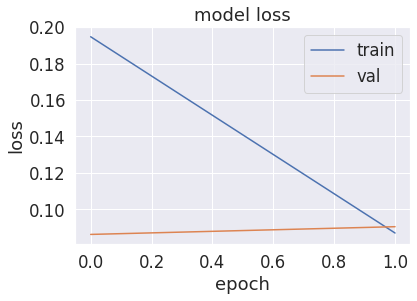

In [ ]:
l, a, p, r = roberta_model.evaluate(test_ds_roberta)

print('Test Loss:', l)
print('Test Accuracy:', a)
print('Test Precision:', p)
print('Test Recall:', r)
print()
plot_history_loss(history_roberta)

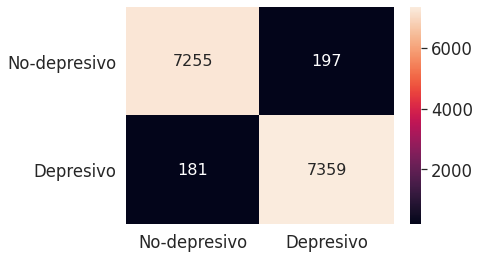

In [ ]:
plot_confusion_matrix(roberta_model, test_ds_roberta)

### Observaciones
Definitivamente este modelo también fue una sorpresa el buen rendimiento que tuvo. Como se puede ver en la gráfica de costo, roberta fue el modelo que mantuvo la pérdida menor en el set de validación, con BERT bastante cerca detrás. Con esto en mente no es sorpresa que tanto las métricas como la matriz hayan salido bastante similares a BERT.

## 3.8 XLNet
Finalmente, se muestra el modelo de XLNet.

In [ ]:
xlnet_model = create_model(xlnet)
xlnet_model.layers[2].trainable = False
xlnet_model.summary()
xlnet_model.compile(optimizer=optimizer, loss=loss, metrics=[acc, precision, recall])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
tfxl_net_model (TFXLNetModel)   TFXLNetModelOutput(l 116718336   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_average_pooling1d_2 (Glo (None, 768)          0           tfxl_net_model[0][0]       

In [ ]:
history_xlnet = xlnet_model.fit(train_ds_xlnet, validation_data=val_ds_xlnet, epochs=EPOCHS)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


547/547 [==============================] - 3380s 6s/step - loss: 0.2278 - accuracy: 0.9438 - precision: 0.9512 - recall: 0.9357 - val_loss: 0.1675 - val_accuracy: 0.9394 - val_precision: 0.9177 - val_recall: 0.9644
Epoch 2/2
547/547 [==============================] - 3366s 6s/step - loss: 0.1459 - accuracy: 0.9482 - precision: 0.9659 - recall: 0.9293 - val_loss: 0.1588 - val_accuracy: 0.9436 - val_precision: 0.9253 - val_recall: 0.9644


118/118 [==============================] - 546s 5s/step - loss: 0.1594 - accuracy: 0.9408 - precision: 0.9220 - recall: 0.9638
Test Loss: 0.15937069058418274
Test Accuracy: 0.9407684206962585
Test Precision: 0.9219741225242615
Test Recall: 0.9637930989265442



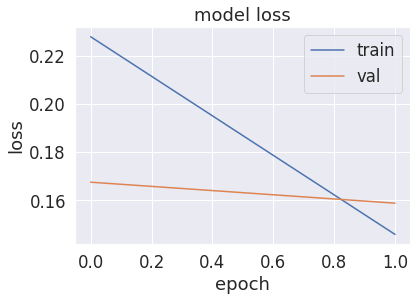

In [ ]:
l, a, p, r = xlnet_model.evaluate(test_ds_xlnet)

print('Test Loss:', l)
print('Test Accuracy:', a)
print('Test Precision:', p)
print('Test Recall:', r)
print()
plot_history_loss(history_xlnet)

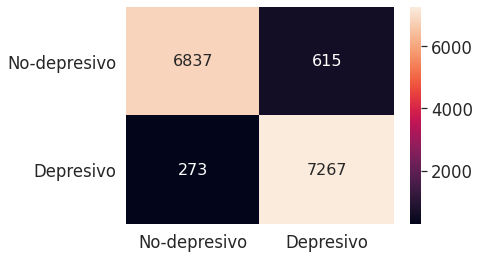

In [ ]:
plot_confusion_matrix(xlnet_model, test_ds_xlnet)

### Observaciones
Se debe admitir que este modelo era para el que se tenían las más altas expectativas, dado que es el modelo más reciente en salir y tomó base en los anteriores en su construcción. No obstante, las métricas obtenidas aquí fueron mucho más bajas de lo que se esperaba. Esto no significa que hayan sido malas, son métricas muy altas, pero comparando con los dos modelos anteriores, este modelo no tuvo un rendimiento extremadamene bueno como los otros.

En cuanto a la razón de esto, hay muchos factores que podrian ser la causa. Por ejemplo, quizás el modelo se necesitaba entrenar por más épocas, pero aqui hay una desventaja grande que es que este modelo consumía casi el doble de tiempo por época que los dos anteriores, lo que hizo agregar más épocas más difícil. La segunda razón pudiera ser que este modelo quizás no está construído con algo simple como clasificación en mente, quizás la intención de los autores era que el modelo pudiera resolver problemas mucho más complicados que esto, como Neural Machine Translation o Text Generation. 

# Conclusiones

Este proyecto tenía como objetivo crear un modelo de procesamiento de lenguaje natural capaz de detectar si un texto contiene un tono depresivo o no, es decir, que puede hacer predicciones sobre si la persona que escribió el texto tiene depresión o no. La depresión ha sido un problema recurrente a través de los años, y es uno de los desafíos más grandes en el área de NLP, ddebido a que la mayoría de las veces las señales que da alguien con depresión pueden llegar a ser sumamente sutiles.

En cuanto a los resultados obtenidos, se piensa que el dataset que se creó para entrenar los modelos contiene una muy buena variedad de textos, con  ideas y estructuras variadas. Sus principales limitaciones eran que se están haciendo generalizciones grandes, al no estudiar completamente de cerca los textos recolectados. La otra limitación importante es el tamaño del mismo dataset. No obstante, se piensa que para este proyecto en particular fue un costo que se tuvo que pagar para que los modelos fueran un poco más ágiles en su entrenamiento, además de que sí se tenían más textos con los cuales trabajar, sólo sería cuestión de incorporarlos al dataset.

Los modelos en sí obtuvieron resultados bastante buenos, por algo son conocidos en la acualidad como el estado-del-arte. La librería que proporciona HuggingFace fue extremadamente útil para incorporar estos modelos de una manera muy, muy sencilla. 

Finalmente, algunas limitaciones y áreas de oportunidad que tiene este proyecto son:
- Los modelos por ahora detectan depresión sobre textos que muy explícitamente tengan palabras relacionadas a la depresión, o bien, que el tono del texto sea muy evidente que es depresivo. Se puede mejorar que los modelos aprendan a marcar como depresivos textos con indicadores más sutiles.

- No se están incorporando metadatos de los textos. Como hicieron los autores en el paper original, ellos tomaron ciertas medidas adicionales sobre los mismos textos para ayudarlos a saber cuándo detectar depresión o no. Aún así, se piensa que esto hubiera sido un poco difícil de aplicar en este proyecto, ya que el acercamiento del paper al problema era distinto. Ahí los autores examinaron una serie de textos sobre un mismo usuario, mientras que aquí se analizaron los textos de manera independiente.

- Por ahora el transfer learning que se hace a los modelos fue bastante pequeño, debido al poco tiempo de trabajo en el proyecto. Muy fácilmente se pueden entrenar estos modelos con un dataset de textos más completo para que le aprendizaje sea todavía mejor.

- Es muy probable que se puedan incorporar otros modelos distintos que sirvan igual o mejor a los que ya se implementaron.

# Referencias consultadas
Las principales referencias que se consultaron para este proyecto fueron:
- https://www.who.int/es/news-room/fact-sheets/detail/depression
- https://www.kaggle.com/nikhileswarkomati/suicide-watch/version/13
- https://github.com/microsoft/nlp-recipes
- https://www.aclweb.org/anthology/W18-5903.pdf
- https://huggingface.co/models
- https://towardsdatascience.com/tensorflow-and-transformers-df6fceaf57cc
- https://medium.com/dataseries/why-does-xlnet-outperform-bert-da98a8503d5b
- https://www.iartificial.net/precision-recall-f1-accuracy-en-clasificacion/
- https://ai.facebook.com/blog/roberta-an-optimized-method-for-pretraining-self-supervised-nlp-systems/
- https://www.tensorflow.org/tutorials/distribute/save_and_load


In [ ]:
# Comando para obtener el archivo de requerimientos
# pip freeze > requirements.txt